In [82]:
import onnxruntime as ort
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from argparse import ArgumentParser
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from src.utils.DataLoader import HidaDataLoader
import pandas as pd
import scipy.special as sc
import numpy as np
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import os

from transformers import ViTFeatureExtractor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns

In [2]:
transform = transforms.Compose([
    transforms.CenterCrop(size=(900,900)),
    transforms.ToTensor()
])

# get predictions from ResNet image classifier1:

In [3]:
dl = HidaDataLoader(num_workers=0, batch_size=8, data_path="../data", transform=transform)
dl.train_split = 0.6
dl.setup()

ONNX_FILE = "C:/Users/Tobias/PycharmProjects/HIDA_LFL/logs/checkpoints/HIDA/model_193.onnx"
options = ort.SessionOptions()
options.inter_op_num_threads = 12
options.intra_op_num_threads = 12

ort_sess = ort.InferenceSession(ONNX_FILE, sess_options=options)
ort_sess.get_inputs()[0].name

valid_dataloader = dl.val_dataloader()

input_name = ort_sess.get_inputs()[0].name
output_name = ort_sess.get_outputs()[0].name

predictions = []
targets = []

counter = 0
tmpfile = "tmpfile1.csv"
if os.path.isfile(tmpfile):
    resnet_df = pd.read_csv(tmpfile)
else:
    for batch in tqdm(valid_dataloader):
        model_input, label, (label_name, image_name) = batch

        outputs_single = sc.expit(ort_sess.run([output_name], {input_name: model_input.cpu().numpy()})[0]).T[0]
        predictions += list(outputs_single)
        targets += list(image_name)
        counter += 1

    resnset_results = dict(predictions_resnet=predictions, images=targets)
    resnet_df = pd.DataFrame(resnset_results)
    resnet_df.to_csv(tmpfile)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [06:42<00:00,  9.15s/it]


In [4]:
# dl = HidaDataLoader(num_workers=0, batch_size=2, data_path="../data", transform=transform)
# dl.train_split = 0.6
# dl.setup()

# ONNX_FILE = "C:/Users/Tobias/Downloads/model_9.onnx"
# options = ort.SessionOptions()
# options.inter_op_num_threads = 12
# options.intra_op_num_threads = 12

# ort_sess2 = ort.InferenceSession(ONNX_FILE, sess_options=options)
# ort_sess2.get_inputs()[0].name

# valid_dataloader = dl.val_dataloader()

# input_name = ort_sess2.get_inputs()[0].name
# output_name = ort_sess2.get_outputs()[0].name

# predictions = []
# targets = []


# feature_extractor = ViTFeatureExtractor(do_resize=False, do_normalize=False)

# counter = 0
# for batch in tqdm(valid_dataloader):
#     model_input, label, (label_name, image_name) = batch
#     features = feature_extractor(model_input, return_tensors="pt")
#     outputs_single = sc.expit(ort_sess2.run([output_name], {input_name: features["pixel_values"][0]})[0]).T[0]
#     predictions += list(outputs_single)
#     targets += list(image_name)
#     counter += 1

# vision_results = dict(predictions_resnet=predictions, images=targets)
# vision_df = pd.DataFrame(vision_results)

# impute datasets:


In [5]:

train_data = "../data/trainSet/trainSet.txt"
test_data = "../data/testSet/testSet.txt"

df_train = pd.read_csv(train_data)
df_train_length_idx = len(df_train)
df_test = pd.read_csv(test_data)

# Merge the two datasets
train_test = [df_train, df_test]
df_train_test = pd.concat(train_test)
# df_train_test['Prognosis'].loc[df_train_test['Prognosis'] == '<undefined>'] = np.nan
df_train_test.loc[df_train_test['Prognosis'] == '<undefined>', 'Prognosis'] = np.nan

# all variables in the dataset (incl. outcome)
variables = list(df_train_test.columns[3:])
# which variables to use for catboost (only numerical ones!)
variables_for_regression = ['WBC', 'Temp_C', 'CRP', 'Fibrinogen', 'LDH', 'Ddimer', 'Ox_percentage', 'PaO2', 'SaO2', 'pH', 'Age']
variables_for_classification = [ 'RespiratoryFailure', 'Sex', 'CardiovascularDisease', 'DifficultyInBreathing', 'Cough']

# Set up catboost for each variable separately
# Here we don't update and always use the original dataset with missing values in all variables

# Generate new dataframe for imputed values (for this we copy the original test_trai datetset and store the index of the imputed ones and fill them in)
df_imputed_train_test = df_train_test.copy()
del df_imputed_train_test['Prognosis']

# Prognosis should be Boolian
df_imputed_train_test['Prognosis']= np.nan
df_imputed_train_test.loc[df_train_test['Prognosis']=='MILD', 'Prognosis'] = 0
df_imputed_train_test.loc[df_train_test['Prognosis']=='SEVERE', 'Prognosis'] = 1


df_train_test['Prognosis'] = df_imputed_train_test['Prognosis']

if not os.path.isfile("imputed_test.csv"):
    for catboost_variable in variables_for_regression:
        print(catboost_variable)
        catboost_features = variables.copy()
        catboost_features.remove(catboost_variable)
        catboost_df_train_test = df_train_test[df_train_test[catboost_variable].notna()]
        X_train = catboost_df_train_test[catboost_features]
        y_train = catboost_df_train_test[catboost_variable]

        index_missing = df_train_test[catboost_variable].isna()
        catboost_df_test = df_train_test[df_train_test[catboost_variable].isna()]
        X_test = catboost_df_test[catboost_features]
        y_test = catboost_df_test[catboost_variable]

        # fit the model 
        model = CatBoostRegressor(verbose=0, iterations=1000, task_type="GPU", devices='0:1')
        model.fit(X_train.values, y_train.values)

        # make a prediction
        yhat = model.predict(X_test.values)
        df_imputed_train_test.loc[df_imputed_train_test[catboost_variable].isna(), catboost_variable] = yhat.T[0].copy()


    for catboost_variable in variables_for_classification:
        print(catboost_variable)
        catboost_features = variables.copy()
        catboost_features.remove(catboost_variable)
        catboost_df_train_test = df_train_test[df_train_test[catboost_variable].notna()]
        X_train = catboost_df_train_test[catboost_features]
        y_train = catboost_df_train_test[catboost_variable]

        index_missing = df_train_test[catboost_variable].isna()
        catboost_df_test = df_train_test[df_train_test[catboost_variable].isna()]
        X_test = catboost_df_test[catboost_features]
        y_test = catboost_df_test[catboost_variable]

        # fit the model 
        model = CatBoostClassifier(verbose=0, iterations=1000, task_type="GPU", devices='0:1')
        model.fit(X_train.values, y_train.values)

        # make a prediction
        yhat = model.predict(X_test.values)
        df_imputed_train_test.loc[df_imputed_train_test[catboost_variable].isna(), catboost_variable] = yhat.T[0].copy()

    # separate the two datasets:
    df_imputed_train = df_imputed_train_test.iloc[0:df_train_length_idx, : ]
    df_imputed_test = df_imputed_train_test.iloc[df_train_length_idx:, :]

    df_imputed_train.to_csv("imputed_train.csv")
    df_imputed_test.to_csv("imputed_test.csv")

else:
    df_imputed_train = pd.read_csv("imputed_train.csv")
    df_imputed_test = pd.read_csv("imputed_test.csv")


# Train tabular models
### train catboost not imputed:

In [6]:
df_for_rf = df_train.copy()
df_for_rf["Prognosis"] = df_for_rf["Prognosis"].astype("category").cat.codes
df_for_rf = df_for_rf[variables]

catboost_features = variables.copy()
catboost_features.remove("Prognosis")

train_valid_split = 0.8
sep_index = int(863 * train_valid_split)

X_train = df_for_rf[catboost_features].iloc[0:sep_index]
y_train = df_for_rf["Prognosis"].iloc[0:sep_index]


X_test = df_for_rf[catboost_features].iloc[sep_index:]
y_test = df_for_rf["Prognosis"].iloc[sep_index:]
image_names = df_train["ImageFile"].iloc[sep_index:]

# fit the model 
cat_boost_raw_model = CatBoostClassifier(verbose=0, iterations=1000, task_type="GPU", devices='0:1')
cat_boost_raw_model.fit(X_train.values, y_train.values)

### xgboost not imputed

In [7]:
# get predictions from xgboost not imputed:
df_for_xg = df_train.copy()
df_for_xg["Prognosis"] = df_for_xg["Prognosis"].astype("category").cat.codes
df_for_xg = df_for_xg[variables]

xgboost_features = variables.copy()
xgboost_features.remove("Prognosis")

train_valid_split = 0.8
sep_index = int(863 * train_valid_split)

X_train = df_for_xg[xgboost_features].iloc[0:sep_index]
y_train = df_for_xg["Prognosis"].iloc[0:sep_index]


X_test = df_for_xg[xgboost_features].iloc[sep_index:]
y_test = df_for_xg["Prognosis"].iloc[sep_index:]
image_names = df_train["ImageFile"].iloc[sep_index:]

# fit model on training data
model_xboost = XGBClassifier()
model_xboost.fit(X_train.values, y_train.values)

[13:24:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Tobias\Anaconda3\envs\pytorch_local\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### lgblight not imputed

In [8]:
# get predictions from LightGBM not imputed:
LGBM_features = variables.copy()
LGBM_features.remove("Prognosis")

train_valid_split = 0.8
sep_index = int(863 * train_valid_split)

X_train = df_for_xg[LGBM_features].iloc[0:sep_index]
y_train = df_for_xg["Prognosis"].iloc[0:sep_index]


X_test = df_for_xg[LGBM_features].iloc[sep_index:]
y_test = df_for_xg["Prognosis"].iloc[sep_index:]
image_names = df_train["ImageFile"].iloc[sep_index:]

# fit model on training data
lgb_model_raw = LGBMClassifier()
lgb_model_raw.fit(X_train.values, y_train.values)

LGBMClassifier()

### train catboost imputed:

In [9]:
catboost_features = variables.copy()
catboost_features.remove("Prognosis")

train_valid_split = 0.8
sep_index = int(863 * train_valid_split)

X_train = df_imputed_train[catboost_features].iloc[0:sep_index]
y_train = df_imputed_train["Prognosis"].iloc[0:sep_index]

X_test = df_imputed_train[catboost_features].iloc[sep_index:]
y_test = df_imputed_train["Prognosis"].iloc[sep_index:]
image_names = df_train["ImageFile"].iloc[sep_index:]

# fit the model
cat_boost_imputed_model = CatBoostClassifier(verbose=0, iterations=1000, task_type="GPU", devices='0:1')
cat_boost_imputed_model.fit(X_train.values, y_train.values)

### train imputed random forest:

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

rf_regressor = RandomForestRegressor(n_estimators=20, random_state=0)
rf_regressor.fit(X_train_scaled, y_train)

RandomForestRegressor(n_estimators=20, random_state=0)

### xgboost imputed 

In [11]:
# fit model on training data
model_xboost_imputed = XGBClassifier()
model_xboost_imputed.fit(X_train.values, y_train.values)


[13:25:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Tobias\Anaconda3\envs\pytorch_local\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Get predictions to train final catboost:

In [22]:
# from catboost raw:
df_for_rf = df_train.copy()
df_for_rf["Prognosis"] = df_for_rf["Prognosis"].astype("category").cat.codes
df_for_rf = df_for_rf[variables]

catboost_features = variables.copy()
catboost_features.remove("Prognosis")

train_valid_split = 0.6
sep_index = int(863 * train_valid_split)

X_test = df_for_rf[catboost_features].iloc[sep_index:]
y_test = df_for_rf["Prognosis"].iloc[sep_index:]
image_names = df_train["ImageFile"].iloc[sep_index:]

yhat = cat_boost_raw_model.predict(X_test.values)

catboost_results = dict(predictions_cb_raw=list(yhat), images=image_names.to_list())
catboost_results_df = pd.DataFrame(catboost_results)

# from xgboost raw:
X_test = df_for_xg[xgboost_features].iloc[sep_index:]
y_test = df_for_xg["Prognosis"].iloc[sep_index:]
image_names = df_train["ImageFile"].iloc[sep_index:]
y_pred = model_xboost.predict(X_test.values)
xgboost_results = dict(predictions_xg=list(y_pred), images=image_names.to_list())
xgboost_results_df = pd.DataFrame(xgboost_results)

# from lgblight raw:
y_pred = lgb_model_raw.predict(X_test.values)
LGBM_results = dict(predictions_LGBM=list(y_pred), images=image_names.to_list())
LGBM_results_df = pd.DataFrame(LGBM_results)

# from catbtoost imputed:
catboost_features = variables.copy()
catboost_features.remove("Prognosis")

X_test = df_imputed_train[catboost_features].iloc[sep_index:]
y_test = df_imputed_train["Prognosis"].iloc[sep_index:]
image_names = df_train["ImageFile"].iloc[sep_index:]

yhat = cat_boost_imputed_model.predict(X_test.values)

catboost_imputed_results = dict(predictions_cb_imputed=list(yhat), images=image_names.to_list(), targets=y_test.values)
catboost_imputed_results_df = pd.DataFrame(catboost_imputed_results)

# from random forest:
X_test_scaled = scaler.transform(X_test.values)
y_pred = rf_regressor.predict(X_test_scaled)

rf_results = dict(predictions_rf=list(y_pred), images=image_names.to_list())
rf_results_df = pd.DataFrame(rf_results)


# from xgboost imputed:
y_pred = model_xboost_imputed.predict(X_test.values)
xgboost_imputed_results = dict(predictions_xg_imputed=list(y_pred), images=image_names.to_list())
xgboost_imputed_results_df = pd.DataFrame(xgboost_imputed_results)

C:\Users\Tobias\Anaconda3\envs\pytorch_local\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Tobias\Anaconda3\envs\pytorch_local\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


# Stack predicions and train final model:

In [23]:
rf_results_df = rf_results_df.set_index("images")
catboost_imputed_results_df = catboost_imputed_results_df.set_index("images")
catboost_results_df = catboost_results_df.set_index("images")
resnet_df = resnet_df.set_index("images")
xgboost_imputed_results_df = xgboost_imputed_results_df.set_index("images")
xgboost_results_df = xgboost_results_df.set_index("images")
LGBM_results_df = LGBM_results_df.set_index("images")

In [24]:
all_predictions = pd.concat([rf_results_df, catboost_imputed_results_df, catboost_results_df, resnet_df, xgboost_imputed_results_df, xgboost_results_df, LGBM_results_df], axis=1)
X_train = all_predictions.drop(columns="targets").values[:-10]
X_test = all_predictions.drop(columns="targets").values[-10:]
y_train = all_predictions["targets"].values[:-10]
y_test = all_predictions["targets"].values[-10:]

# final stacking model:
final_model = CatBoostClassifier(verbose=0, iterations=1000, task_type="GPU", devices='0:1')
final_model.fit(X_train, y_train)
yhat = final_model.predict(X_test)

In [25]:
yhat

array([0., 0., 1., 1., 1., 1., 1., 0., 1., 0.])

# Get final predictions on testset for submission:

In [75]:
# from resnet:
dl = HidaDataLoader(num_workers=0, batch_size=8, data_path="../data", transform=transform)
dl.setup(stage="test")

predictions = []
targets = []
test_dataloader = dl.test_dataloader()

counter = 0
tmpfile = "tmpfile2.csv"
if os.path.isfile(tmpfile):
    resnet_df = pd.read_csv(tmpfile)
else:
    for batch in tqdm(test_dataloader):
        model_input, label, (label_name, image_name) = batch
        outputs_single = sc.expit(ort_sess.run([output_name], {input_name: model_input.cpu().numpy()})[0]).T[0]
        predictions += list(outputs_single)
        targets += list(image_name)

    resnset_results = dict(predictions_resnet=predictions, images=targets)
    resnet_df = pd.DataFrame(resnset_results)
    resnet_df["images"] = resnet_df["images"].apply(lambda x: x.split(".")[0])
    resnet_df.to_csv(tmpfile)

# from catboost raw:
df_for_rf = df_test.copy()
df_for_rf["Prognosis"] = df_for_rf["Prognosis"].astype("category").cat.codes
df_for_rf = df_for_rf[variables]

catboost_features = variables.copy()
catboost_features.remove("Prognosis")

X_test = df_for_rf[catboost_features]
y_test = df_for_rf["Prognosis"]
image_names = df_test["PatientID"]

yhat = cat_boost_raw_model.predict(X_test.values)

catboost_results = dict(predictions_cb_raw=list(yhat), images=image_names.to_list())
catboost_results_df = pd.DataFrame(catboost_results)

# from lgblight raw:
y_pred = lgb_model_raw.predict(X_test.values)
LGBM_results = dict(predictions_LGBM=list(y_pred), images=image_names.to_list())
LGBM_results_df = pd.DataFrame(LGBM_results)


# from xgboost raw:
y_pred = model_xboost.predict(X_test.values)
xgboost_results = dict(predictions_xg=list(y_pred), images=image_names.to_list())
xgboost_results_df = pd.DataFrame(xgboost_results)

# from catbtoost imputed:
catboost_features = variables.copy()
catboost_features.remove("Prognosis")

X_test = df_imputed_test[catboost_features]
y_test = df_imputed_test["Prognosis"]
image_names = df_test["PatientID"]

yhat = cat_boost_imputed_model.predict(X_test.values)

catboost_imputed_results = dict(predictions_cb_imputed=list(yhat), images=image_names.to_list(), targets=y_test.values)
catboost_imputed_results_df = pd.DataFrame(catboost_imputed_results)

# from random forest:
X_test_scaled = scaler.transform(X_test.values)
y_pred = rf_regressor.predict(X_test_scaled)

rf_results = dict(predictions_rf=list(y_pred), images=image_names.to_list())
rf_results_df = pd.DataFrame(rf_results)

# from xgboost imputed:
y_pred = model_xboost_imputed.predict(X_test.values)
xgboost_imputed_results = dict(predictions_xg_imputed=list(y_pred), images=image_names.to_list())
xgboost_imputed_results_df = pd.DataFrame(xgboost_imputed_results)

C:\Users\Tobias\Anaconda3\envs\pytorch_local\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Tobias\Anaconda3\envs\pytorch_local\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [76]:
catboost_imputed_results_df

,predictions_cb_imputed,images,targets
0,0.0,P_102,NaN
1,0.0,P_117,NaN
2,0.0,P_16,NaN
3,0.0,P_118,NaN
4,0.0,P_114,NaN
...,...,...,...
115,0.0,P_88,NaN
116,0.0,P_92,NaN
117,1.0,P_86,NaN
118,1.0,P_9,NaN


### stack final predictions

In [77]:
# stack predicions:
rf_results_df = rf_results_df.set_index("images")
catboost_imputed_results_df = catboost_imputed_results_df.set_index("images")
catboost_results_df = catboost_results_df.set_index("images")
resnet_df = resnet_df.set_index("images")
resnet_df = resnet_df.drop(columns="Unnamed: 0")
xgboost_imputed_results_df = xgboost_imputed_results_df.set_index("images")
xgboost_results_df = xgboost_results_df.set_index("images")
LGBM_results_df = LGBM_results_df.set_index("images")

In [78]:
# make final prediction:
all_predictions = pd.concat([rf_results_df, catboost_imputed_results_df, catboost_results_df, resnet_df, xgboost_imputed_results_df, xgboost_results_df, LGBM_results_df], axis=1)
X_test = all_predictions.drop(columns="targets").values
yhat = final_model.predict(X_test)

In [80]:
all_predictions["Prognosis"] = yhat
all_predictions

,predictions_rf,predictions_cb_imputed,targets,predictions_cb_raw,predictions_resnet,predictions_xg_imputed,predictions_xg,predictions_LGBM,Prognosis
images,,,,,,,,,
P_102,0.35,0.0,NaN,0,0.462840,0.0,0,0,0.0
P_117,0.40,0.0,NaN,0,NaN,0.0,0,0,0.0
P_16,0.05,0.0,NaN,0,0.479481,0.0,0,0,0.0
P_118,0.35,0.0,NaN,0,0.488003,0.0,1,1,1.0
P_114,0.25,0.0,NaN,0,0.507168,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...
P_88,0.25,0.0,NaN,0,NaN,0.0,0,0,0.0
P_92,0.20,0.0,NaN,0,0.445237,0.0,0,0,0.0
P_86,0.55,1.0,NaN,1,0.454971,1.0,0,1,1.0


In [46]:
df_out = pd.read_csv(test_data)

for column in df_imputed_test.columns:
    if column in df_out.columns:
        df_out[column] = df_imputed_test[column]
        
df_out["Prognosis"] = yhat
df_out["Prognosis"] = df_out["Prognosis"].apply(lambda x: "MILD" if x == 0 else "SEVERE")
df_out.to_csv("final_submission_lightning_fast_learner.txt", index=False)
df_out.to_csv("final_submission_lightning_fast_learner.csv", index=False)

In [47]:
df_out

,PatientID,ImageFile,Hospital,Age,Sex,Temp_C,Cough,DifficultyInBreathing,WBC,CRP,Fibrinogen,LDH,Ddimer,Ox_percentage,PaO2,SaO2,pH,CardiovascularDisease,RespiratoryFailure,Prognosis
0,P_102,P_102.png,A,81.920072,1.0,37.30000,1.0,0.0,5.370000,3.960000,621.944903,297.317793,4847.134382,93.000000,63.0,93.000000,7.46000,0.0,0.0,MILD
1,P_117,NaN,A,39.000000,1.0,37.76346,1.0,0.0,10.170000,0.750000,621.944903,297.317793,4847.134382,95.000000,77.0,97.000000,7.47873,1.0,0.0,MILD
2,P_16,P_16.png,A,44.000000,0.0,38.00000,1.0,0.0,5.814336,5.200000,621.944903,297.317793,4847.134382,96.600503,65.0,94.000000,7.47000,0.0,0.0,SEVERE
3,P_118,P_118.png,A,81.920072,0.0,37.76346,1.0,0.0,17.720000,13.720000,621.944903,297.317793,4847.134382,96.600503,53.0,94.728545,7.60000,0.0,0.0,SEVERE
4,P_114,P_114.png,A,51.000000,1.0,37.76346,0.0,1.0,5.814336,22.509886,621.944903,297.317793,4847.134382,96.600503,90.0,98.000000,7.56000,0.0,0.0,SEVERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,P_88,NaN,A,58.000000,0.0,36.70000,1.0,0.0,5.140000,22.509886,621.944903,297.317793,4847.134382,96.600503,89.0,99.000000,7.56000,1.0,0.0,MILD
116,P_92,P_92.png,A,48.000000,0.0,37.40000,1.0,0.0,5.170000,2.600000,621.944903,178.000000,4847.134382,88.000000,83.0,94.728545,7.42000,1.0,0.0,SEVERE
117,P_86,P_86.png,A,87.000000,0.0,37.50000,1.0,0.0,8.100000,20.760000,621.944903,297.317793,4847.134382,89.000000,60.0,93.000000,7.43000,1.0,0.0,SEVERE
118,P_9,P_9.png,A,70.000000,1.0,38.00000,0.0,1.0,3.610000,9.520000,621.944903,297.317793,552.000000,96.600503,41.0,77.000000,7.44000,1.0,0.0,SEVERE


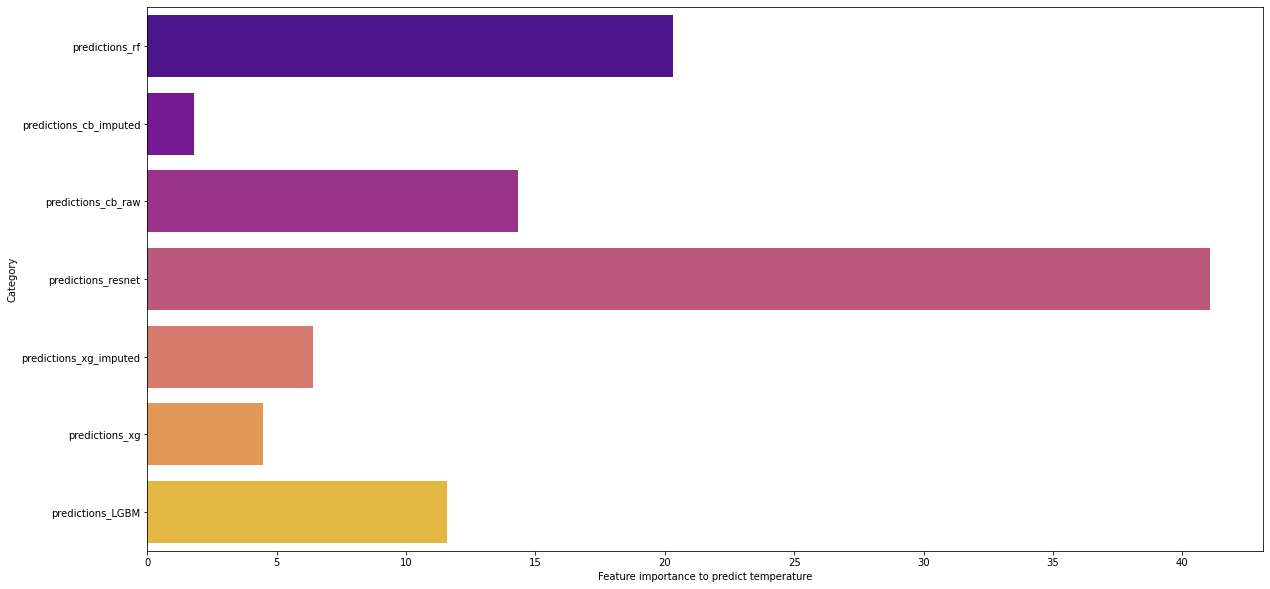

In [88]:
importance = final_model.get_feature_importance(type= "FeatureImportance")
# histplot of missing data:
fig, ax = plt.subplots(figsize=(20,10))
g = sns.barplot(x=importance, y=all_predictions.drop(columns=["Prognosis", "targets"]).columns, palette="plasma", ax=ax)
ax.set_xlabel("Feature importance to predict Prognosis")
ax.set_ylabel("Category")
plt.show()